In [2]:
import jieba
import jieba.analyse
import requests
import re
import time
from bs4 import BeautifulSoup
import pandas as pd
from wordcloud import WordCloud
from PIL import Image


Bad val 'Flase' on line #329
	"axes.unicode_minus  : Flase    ## use unicode for the minus symbol
"
	in file "/Users/louis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key axes.unicode_minus: Could not convert "flase" to boolean


In [3]:
url='https://www.ptt.cc/bbs/HatePolitics/index.html'
table=[]
for page in range(1,2):
    headers={'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
    r=requests.get(url, headers=headers,cookies={'over18':'1'})
    r.encoding='utf-8'
    bs=BeautifulSoup(r.text,'lxml')
    n=bs.find('div',attrs={'class':'r-list-container action-bar-margin bbs-screen'})
    dfs=[]
    for i in n:
        #print(len(i))
        if len(i)==7:
            if i.find('div',attrs={'class':'author'}).text!= '-':
                title_url=i.find('div',attrs={'class':'title'}).a['href']
                title_urls='https://www.ptt.cc/'+title_url
                #print(title_urls)
                title_r=requests.get(title_urls, headers=headers,cookies={'over18':'1'})
                title_bs=BeautifulSoup(title_r.text,'lxml')
                title=title_bs.find('div',attrs={'class':'article-metaline'}).text
                userid=[]
                content=[]
                ip=[]
                date=[]
                article=[]
                dicts={}

                for push in title_bs.find_all('div',attrs={'class':'push'}):
                    p_userid=push.find(class_='f3 hl push-userid').text
                    p_content=push.find(class_='f3 push-content').text.replace(': ','')
                    #print(p_content)
                    p_ipdate=push.find(class_='push-ipdatetime').text
                    #print(p_ipdate)
                    #p_ip=re.compile('[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+\ ').search(str(p_ipdate))
                    #if  not p_ip ==None:
                    #    p_ip=re.compile('[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+\ ').search(str(p_ipdate)).group()
                    #    p_date=re.compile('[0-9]+\/[0-9]+\ [0-9]+\:[0-9]+').search(str(p_ipdate)).group()
                    p_article=title_bs.find_all('div', attrs={'class':'article-metaline'})[1].find(class_='article-meta-value').text
                    userid.append(p_userid)
                    content.append(p_content)
                    #ip.append(p_ip)
                    #date.append(p_date)
                    article.append(p_article)
       
                dicts={'userid':userid,'content':content}#,'ip':ip,'date':date}
                df=pd.DataFrame(dicts)
                df['article']=article
                dfs.append(df)
                time.sleep(1)
        elif str(i)=='<div class="r-list-sep"></div>':
            break
    #print(len(dfs))

    for lenght in range(1,len(dfs)):
        dfs[0]=pd.concat([dfs[0],dfs[lenght]])
    #print(dfs[0])
    table.append(dfs[0])
    
    url='https://www.ptt.cc/'+bs.find('div',attrs={'class':'btn-group btn-group-paging'}).find_all('a')[1]['href']
    time.sleep(1)
for lenght in range(1,len(table)):
        table[0]=pd.concat([table[0],table[lenght]])
ptt_reply=table[0].astype(str)
print(ptt_reply)

         userid                      content                  article
0     serval623      民眾黨可以立法挺案禁止墮胎啊 不提案就是挺墮胎     Re: [討論] 總統府發言人都在墮胎了
1     PunkGrass                    推 支持墮胎除罪化     Re: [討論] 總統府發言人都在墮胎了
2          womf          怎麼從來沒看到新聞有提過有人墮胎被關啊     Re: [討論] 總統府發言人都在墮胎了
3   iamalam2005                      通常都會緩刑啦     Re: [討論] 總統府發言人都在墮胎了
4       adagiox               原來美屬台灣還有這種落後法條     Re: [討論] 總統府發言人都在墮胎了
..          ...                          ...                      ...
9    miler22020     幹  在喜的人說別人洗  我快笑死  不愧是藍畜  [新聞] 網虧「綠色是原諒的顏色」！要丁允恭別
10     Gavatzky    綠狗拼命洗文章說打砲是私事 然後把美豬洗掉 有夠神  [新聞] 網虧「綠色是原諒的顏色」！要丁允恭別
11   miler22020                 趕快去討論美豬啦 某藍畜  [新聞] 網虧「綠色是原諒的顏色」！要丁允恭別
12  smile810601       犧牲小我 加油再撐一下 美豬爐渣就安全下莊了  [新聞] 網虧「綠色是原諒的顏色」！要丁允恭別
13      Landius  這個應該不是開玩笑,反正都是要升的,把女方玩壞了沒差.  [新聞] 網虧「綠色是原諒的顏色」！要丁允恭別

[261 rows x 3 columns]


In [4]:
#新增詞彙
jieba.load_userdict('/Users/louis/Desktop/ptt/HatePolitics_jieba.txt')
stopWords=[]
segments=[]
remainderWords=[]
# 讀入停用詞檔
with open('stopWords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wq/q_lk1_8n5h7125py_r5_63nc0000gp/T/jieba.cache
Loading model cost 1.196 seconds.
Prefix dict has been built successfully.


In [5]:
data=ptt_reply.groupby(by='userid').apply(lambda x:[','.join(x['content'])]).astype(str)
h_tpp={}
h_dpp={}
h_kmt={}
no_hater={}
ttp_count=0
ddp_count=0
kmt_count=0
count=0
author_count=0
for i in data:
    key_words=jieba.analyse.extract_tags(i, topK=10, withWeight=False, allowPOS=())
    if '柯糞' in key_words or '柯屁' in key_words or '柯師傅' in key_words:
        if len(key_words)==10:
            h_tpp.setdefault(data.index[author_count],key_words)
            ttp_count+=1
            


    elif '菸粉' in key_words or '817' in key_words or '菸糞' in key_words or '英糞' in key_words or '綠畜' in key_words:
         if len(key_words)==10:
            h_dpp.setdefault(data.index[author_count],key_words)
            ddp_count+=1


    elif '韓導' in key_words or '憨導' in key_words or '552' in key_words or '韓總機' in key_words or '憨粉' in key_words:
         if len(key_words)==10:
                h_kmt.setdefault(data.index[author_count],key_words)
                kmt_count+=1


    else:
        no_hater.setdefault(data.index[author_count],key_words)
        count+=1
    author_count+=1

print('柯黑人數：',ttp_count)
print('英黑人數：',ddp_count)
print('韓黑人數：',kmt_count)
print('無明顯跡象：',count)

tpp_value=[]
dpp_value=[]
kmt_value=[]
tpp_key=[]
dpp_key=[]
kmt_key=[]

#人名
for i in h_tpp.keys():
    tpp_key.append(i)
print('柯黑：',tpp_key)
for i in h_dpp.keys():
    dpp_key.append(i)
print('英黑：',dpp_key)
for i in h_kmt.keys():
    kmt_key.append(i)
print('韓黑：',kmt_key)

柯黑人數： 0
英黑人數： 0
韓黑人數： 0
無明顯跡象： 88
柯黑： []
英黑： []
韓黑： []


In [6]:
data

userid
BravoStar                                             ['你阿姨也癢']
Cordierite                                             ['真的+1']
Crazyfire                                                ['呀比']
Dia149                                                ['年紀都好大']
Doralice      ['因為第9條第六點幾乎可以涵蓋所有未婚想墮胎、婚外情想,墮胎、夫妻不合希望墮胎的情況了,第...
                                    ...                        
whitenoise                       ['跟共匪當然要楚河漢界，美國都敢斷了,吳宏謀這個最奇葩']
womf          ['怎麼從來沒看到新聞有提過有人墮胎被關啊, 所以是刑法有罪 但又因為優生保健法變無罪這樣？...
wupaul                                                ['競業條款?']
yun0112           ['死魚 雞排勒,你的雞排連本帶利到底欠幾個了啊,升官的時候死魚可以兌現雞排承諾慶祝嗎']
zaqw641125                  ['不要亂用心理學理論好嗎...,對讀心理的看起來很刺目,問陳建州']
Length: 89, dtype: object

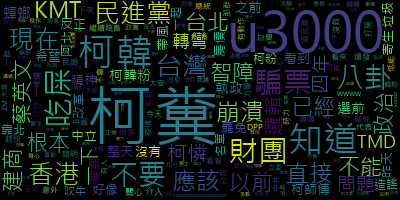

In [31]:
tpp=[]
for i in tpp_key:
    tpp.append(data[i])
text_dpp=str(tpp).replace('[','').replace('"','').replace(']','').replace("'",'').replace('\\','').replace(',','').replace(' ','')
n=jieba.cut(text_dpp, cut_all=False)
remainderWords =str(list(filter(lambda a: a not in stopWords and a != '\n', n))).replace('[','').replace(']','').replace("'",'')
cloud= WordCloud(font_path='/Users/louis/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/TTC/78992571833.ttc').generate(remainderWords)
cloud.to_file('tpp.png')
#print(cloud)
Image.open("tpp.png")


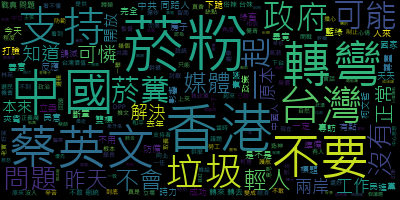

In [32]:
dpp=[]
for i in dpp_key:
    dpp.append(data[i])
text_dpp=str(dpp).replace('[','').replace('"','').replace(']','').replace("'",'').replace('\\','').replace(',','').replace(' ','')
n=jieba.cut(text_dpp, cut_all=False)
remainderWords =str(list(filter(lambda a: a not in stopWords and a != '\n', n))).replace('[','').replace(']','').replace("'",'')
cloud= WordCloud(font_path='/Users/louis/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/TTC/78992571833.ttc').generate(remainderWords)
cloud.to_file('dpp.png')

Image.open("dpp.png")


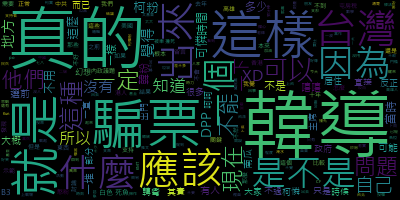

In [33]:
kmt=[]
for i in kmt_key:
    kmt.append(data[i])
text_kmt=str(kmt).replace('[','').replace('"','').replace(']','').replace("'",'')
n='|'.join(jieba.cut(text_kmt, cut_all=False))

cloud= WordCloud(font_path='/Users/louis/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/TTC/78992571833.ttc').generate(n)
cloud.to_file('kmt.png')
Image.open("kmt.png")
